# Model 1: Random Forest Regressor for Automobile Price Prediction

**CS3AM Coursework - Artificial Intelligence & Machine Learning**

---

## Overview

This notebook implements Model 1, a Random Forest Regressor, for predicting automobile prices. Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mean prediction of individual trees (Breiman, 2001).

### Structure
1. Imports and Configuration
2. Data Loading
3. Data Preprocessing
4. Train/Test Split
5. Model Architecture Justification
6. Hyperparameter Tuning with Cross-Validation
7. Model Training
8. Predictions
9. Comprehensive Evaluation Metrics
10. Visualisations
11. Feature Importance Analysis
12. Results Summary

---
## 1. Imports and Configuration

Import all required libraries for data processing, model training, evaluation, and visualisation.

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Scikit-learn: Model and preprocessing
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

# Scikit-learn metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    median_absolute_error,
    max_error
)

# Visualisation settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['figure.figsize'] = (10, 6)

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Ensuring reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully.")
print(f"Random State: {RANDOM_STATE}")

ModuleNotFoundError: No module named 'matplotlib'

---
## 2. Data Loading

Load the Automobile dataset. This dataset contains 205 automobile records with 26 features including specifications, insurance risk ratings and prices.

In [ ]:
# Load dataset
# Note: Update path if running locally
df = pd.read_csv('Automobile_data.csv', na_values='?')

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nShape: {df.shape}")
print(f"Total Samples: {df.shape[0]}")
print(f"Total Features: {df.shape[1]}")

print("\n" + "-" * 60)
print("First 5 Rows:")
print("-" * 60)
df.head()

DATASET OVERVIEW

Shape: (205, 26)
Total Samples: 205
Total Features: 26

------------------------------------------------------------
First 5 Rows:
------------------------------------------------------------


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [2]:
# Check for missing values
print("Missing Values per Column:")
print("-" * 40)
missing = df.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("No missing values found.")

print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing Values per Column:
----------------------------------------


NameError: name 'df' is not defined

---
## 3. Data Preprocessing

Prepare the data for model training:
- Separate features (X) and target variable (y)
- Handle missing values using imputation
- Scale the numerical features using StandardScaler
- Encode the categorical features using OneHotEncoder

In [ ]:
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Remove the rows where target is missing
valid_indices = ~y.isnull()
X = X[valid_indices]
y = y[valid_indices]

print(f"Samples after removing missing targets: {len(y)}")

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical Features ({len(categorical_cols)}):")
print(categorical_cols)
print(f"\nNumeric Features ({len(numeric_cols)}):")
print(numeric_cols)

Samples after removing missing targets: 201

Categorical Features (10):
['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system']

Numeric Features (15):
['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']


In [ ]:
# Create preprocessing pipelines

# Numeric: Impute with median, then standardise
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: Impute with the most frequent, then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine them into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print("Preprocessing pipeline created.")
print("\nPipeline structure:")
print("  Numeric:     Median Imputation -> StandardScaler")
print("  Categorical: Mode Imputation -> OneHotEncoder")

Preprocessing pipeline created.

Pipeline structure:
  Numeric:     Median Imputation -> StandardScaler
  Categorical: Mode Imputation -> OneHotEncoder


---
## 4. Train/Test Split

Split the data into training (80%) and testing (20%) sets. Using the same `random_state=42` as Model 2 ensures fair comparison between the two models.

In [ ]:
# Train/test split (80/20)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("=" * 60)
print("TRAIN/TEST SPLIT")
print("=" * 60)
print(f"\nTraining samples: {len(X_train_raw)}")
print(f"Testing samples:  {len(X_test_raw)}")
print(f"Split ratio:      {len(X_train_raw)/len(X):.0%} / {len(X_test_raw)/len(X):.0%}")

# Apply the preprocessing
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print(f"\nFeatures after preprocessing: {X_train.shape[1]}")

# Convert y to numpy arrays
y_train = y_train.values
y_test = y_test.values

print(f"\nTarget variable (price) statistics:")
print(f"  Training - Mean: ${y_train.mean():,.0f}, Std: ${y_train.std():,.0f}")
print(f"  Testing  - Mean: ${y_test.mean():,.0f}, Std: ${y_test.std():,.0f}")

TRAIN/TEST SPLIT

Training samples: 160
Testing samples:  41
Split ratio:      80% / 20%

Features after preprocessing: 74

Target variable (price) statistics:
  Training - Mean: $12,574, Std: $6,755
  Testing  - Mean: $15,679, Std: $11,061


---
## 5. Model Architecture Justification

### Why did we choose Random Forest for the Automobile Price Prediction?

We selected Random Forest as Model 1 for the following reasons:

**1. Ensemble Learning (Breiman, 2001)**

Random Forest constructs multiple decision trees and aggregates their predictions through averaging. This bagging approach reduces variance without substantially increasing bias, making it robust against overfitting.

**2. Handles Mixed Data Types**

The automobile dataset contains both numerical features (horsepower, engine-size) and categorical features (make, fuel-type). Random Forest's tree-based structure naturally handles this heterogeneous data.

**3. Non-Linear Relationships**

Car pricing involves complex non-linear relationships. For example, luxury brands command exponential premiums. Random Forest captures these patterns without requiring explicit feature engineering.

**4. Feature Importance**

Random Forest provides interpretable feature importance scores, enabling identification of which attributes most influence price predictions. This supports domain understanding and model validation.

**5. Robustness to Outliers**

Unlike linear regression, Random Forest is less sensitive to outliers in the target variable, which our dataset contains in the form of luxury vehicles.

**References:**
- Breiman, L. (2001) 'Random Forests', Machine Learning, 45(1), pp. 5-32.
- Hastie, T., Tibshirani, R. and Friedman, J. (2009) The Elements of Statistical Learning. 2nd edn. New York: Springer.

---
## 6. Hyperparameter Tuning with Cross-Validation

### Hyperparameter Definitions

| Parameter | Description | Impact |
|-----------|-------------|--------|
| `n_estimators` | Number of trees in the forest | More trees = more stable, but slower |
| `max_depth` | Maximum depth of each tree | Deeper = more complex, risk of overfitting |
| `min_samples_split` | Minimum samples to split a node | Higher = more regularisation |
| `min_samples_leaf` | Minimum samples in leaf nodes | Higher = smoother predictions |
| `max_features` | Features considered per split | Lower = more tree diversity |

We use **RandomizedSearchCV** with **5-fold cross-validation** to find optimal hyperparameters, while avoiding overfitting to the test set.

In [ ]:
# Define hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("=" * 60)
print("HYPERPARAMETER SEARCH SPACE")
print("=" * 60)
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal possible combinations: {total_combinations}")
print(f"We will sample 50 combinations randomly.")

HYPERPARAMETER SEARCH SPACE
  n_estimators: [100, 200, 300]
  max_depth: [10, 20, 30, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]

Total possible combinations: 324
We will sample 50 combinations randomly.


In [ ]:
# Perform RandomizedSearchCV
print("\nStarting Randomized Search with 5-Fold Cross-Validation...")
print("(This may take a few minutes)\n")

base_rf = RandomForestRegressor(random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS FOUND")
print("=" * 60)
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation MAE: ${-random_search.best_score_:,.2f}")


Starting Randomized Search with 5-Fold Cross-Validation...
(This may take 1-2 minutes)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

BEST HYPERPARAMETERS FOUND
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: 30

Best Cross-Validation MAE: $1,619.69


---
## 7. Model Training

Train the final Random Forest model using the optimised hyperparameters identified through cross-validation.

In [ ]:
# Create and train the final model
rf_model = RandomForestRegressor(
    **best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Training Random Forest with optimised hyperparameters...")
rf_model.fit(X_train, y_train)

print("\n" + "=" * 60)
print("MODEL TRAINING COMPLETE")
print("=" * 60)
print(f"\nNumber of trees: {rf_model.n_estimators}")
print(f"Number of features: {rf_model.n_features_in_}")

# Cross-validation on the training data
cv_scores = cross_val_score(
    rf_model, X_train, y_train,
    cv=5,
    scoring='neg_mean_absolute_error'
)
print(f"\n5-Fold CV MAE: ${-cv_scores.mean():,.2f} (+/- ${cv_scores.std()*2:,.2f})")

Training Random Forest with optimised hyperparameters...

MODEL TRAINING COMPLETE

Number of trees: 300
Number of features: 74

5-Fold CV MAE: $1,619.69 (+/- $744.93)


---
## 8. Generate Predictions

Apply the trained model to the held-out test set to generate price predictions.

In [ ]:
# Generate predictions
y_pred = rf_model.predict(X_test)

print("=" * 60)
print("SAMPLE PREDICTIONS (First 10)")
print("=" * 60)
print(f"\n{'Actual':>12} {'Predicted':>12} {'Error':>12} {'Error %':>10}")
print("-" * 50)

for i in range(min(10, len(y_test))):
    actual = y_test[i]
    pred = y_pred[i]
    error = actual - pred
    error_pct = (error / actual) * 100
    print(f"${actual:>10,.0f} ${pred:>10,.0f} ${error:>10,.0f} {error_pct:>9.1f}%")

SAMPLE PREDICTIONS (First 10)

      Actual    Predicted        Error    Error %
--------------------------------------------------
$     8,249 $     7,398 $       851      10.3%
$    41,315 $    28,511 $    12,804      31.0%
$     6,855 $     6,485 $       370       5.4%
$     9,258 $     7,990 $     1,268      13.7%
$    11,850 $    13,658 $    -1,808     -15.3%
$     5,572 $     5,909 $      -337      -6.0%
$    35,056 $    29,178 $     5,878      16.8%
$     9,988 $    10,950 $      -962      -9.6%
$    15,998 $    16,783 $      -785      -4.9%
$    35,550 $    31,776 $     3,774      10.6%


---
## 9. Comprehensive Evaluation Metrics

Calculate a full suite of regression metrics to assess the model's performance, as per Lab 2.

| Metric | Description | Interpretation |
|--------|-------------|----------------|
| MAE | Mean Absolute Error | Average prediction deviation in dollars |
| RMSE | Root Mean Squared Error | Penalises large errors more heavily |
| R² | Coefficient of Determination | Proportion of variance explained (0-1) |
| MAPE | Mean Absolute Percentage Error | Error as percentage of actual price |

In [ ]:
# Calculate all the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
explained_var = explained_variance_score(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
max_err = max_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Baseline comparison (mean prediction)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))

# Improvement over baseline
mae_improvement = ((baseline_mae - mae) / baseline_mae) * 100
rmse_improvement = ((baseline_rmse - rmse) / baseline_rmse) * 100

print("=" * 70)
print("TABLE 1: RANDOM FOREST REGRESSOR PERFORMANCE METRICS")
print("=" * 70)
print(f"\n{'Metric':<32} {'Value':<15} {'Interpretation'}")
print("-" * 70)
print(f"{'Mean Absolute Error (MAE)':<32} ${mae:>12,.2f}   Average deviation")
print(f"{'Root Mean Squared Error (RMSE)':<32} ${rmse:>12,.2f}   Penalises large errors")
print(f"{'R² Score':<32} {r2:>13.4f}   Variance explained")
print(f"{'Explained Variance Score':<32} {explained_var:>13.4f}   Similar to R²")
print(f"{'Median Absolute Error':<32} ${median_ae:>12,.2f}   Robust to outliers")
print(f"{'Max Error':<32} ${max_err:>12,.2f}   Worst prediction")
print(f"{'MAPE':<32} {mape:>12.2f}%   Percentage error")
print("-" * 70)

TABLE 1: RANDOM FOREST REGRESSOR PERFORMANCE METRICS

Metric                           Value           Interpretation
----------------------------------------------------------------------
Mean Absolute Error (MAE)        $    2,164.79   Average deviation
Root Mean Squared Error (RMSE)   $    3,499.50   Penalises large errors
R² Score                                0.8999   Variance explained
Explained Variance Score                0.9104   Similar to R²
Median Absolute Error            $      947.83   Robust to outliers
Max Error                        $   12,804.11   Worst prediction
MAPE                                    11.27%   Percentage error
----------------------------------------------------------------------


In [ ]:
# Baseline comparison table
print("\n" + "=" * 70)
print("TABLE 2: COMPARISON WITH BASELINE (Mean Prediction)")
print("=" * 70)
print(f"\n{'Metric':<20} {'Baseline':<18} {'Random Forest':<18} {'Improvement'}")
print("-" * 70)
print(f"{'MAE':<20} ${baseline_mae:>14,.2f}   ${mae:>14,.2f}   {mae_improvement:>10.1f}%")
print(f"{'RMSE':<20} ${baseline_rmse:>14,.2f}   ${rmse:>14,.2f}   {rmse_improvement:>10.1f}%")
print("-" * 70)

# Performance rating
if r2 >= 0.9:
    rating = "Excellent"
elif r2 >= 0.8:
    rating = "Very Good"
elif r2 >= 0.7:
    rating = "Good"
elif r2 >= 0.6:
    rating = "Moderate"
else:
    rating = "Poor"

print(f"\nOverall Performance Rating: {rating}")
print(f"Model explains {r2*100:.1f}% of automobile price variance.")


TABLE 2: COMPARISON WITH BASELINE (Mean Prediction)

Metric               Baseline           Random Forest      Improvement
----------------------------------------------------------------------
MAE                  $      8,262.03   $      2,164.79         73.8%
RMSE                 $     11,488.71   $      3,499.50         69.5%
----------------------------------------------------------------------

Overall Performance Rating: Very Good
Model explains 90.0% of automobile price variance.


---
## 10. Visualisations

Generate publication-quality visualisations to support the results analysis.

### 10.1 Predicted vs Actual Prices

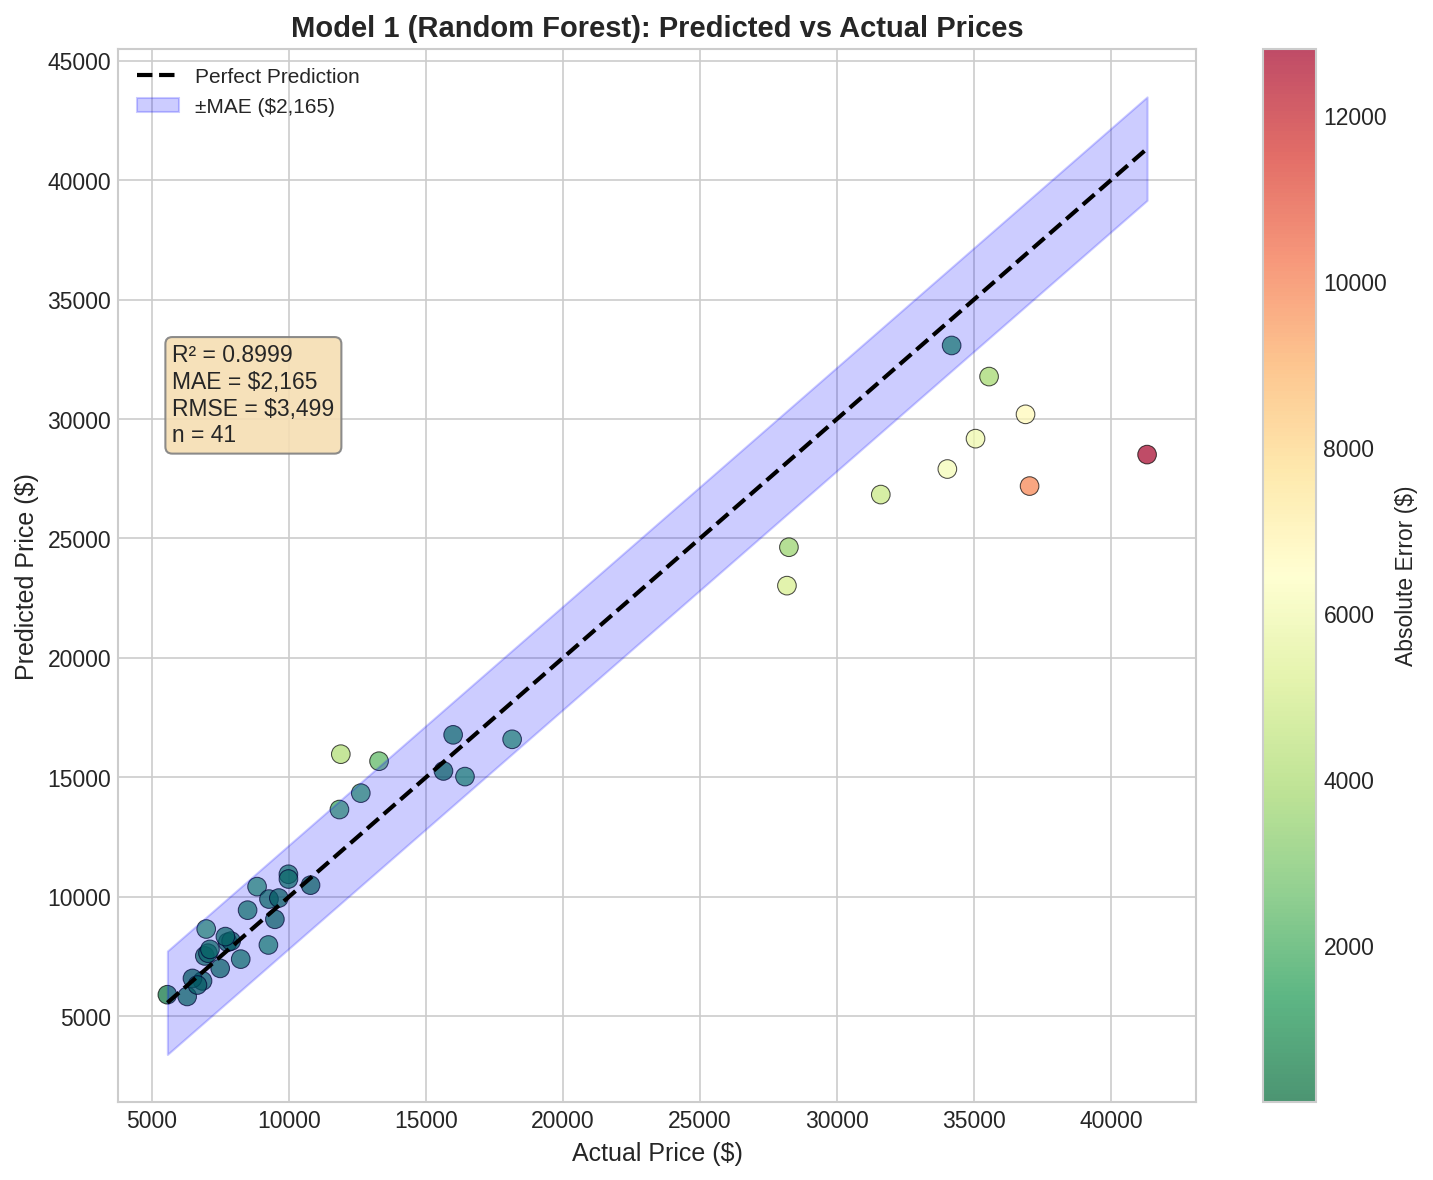

Saved: rf_fig1_predicted_vs_actual.png


In [ ]:
# Figure 1: Predicted vs Actual Scatter Plot
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Calculate errors for the colour gradient
errors = np.abs(y_test - y_pred)

# Scatter plot
scatter = ax1.scatter(
    y_test, y_pred,
    c=errors,
    cmap='RdYlGn_r',
    alpha=0.7,
    edgecolors='black',
    linewidth=0.5,
    s=80
)

# Perfect prediction line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')

# MAE confidence bands
ax1.fill_between(
    [min_val, max_val],
    [min_val - mae, max_val - mae],
    [min_val + mae, max_val + mae],
    alpha=0.2, color='blue', label=f'±MAE (${mae:,.0f})'
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Absolute Error ($)', fontsize=11)

# Labels
ax1.set_xlabel('Actual Price ($)', fontsize=12)
ax1.set_ylabel('Predicted Price ($)', fontsize=12)
ax1.set_title('Model 1 (Random Forest): Predicted vs Actual Prices', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)

# Annotation box

textstr = f'R² = {r2:.4f}\nMAE = ${mae:,.0f}\nRMSE = ${rmse:,.0f}\nn = {len(y_test)}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='gray')
ax1.text(0.05, 0.72, textstr, transform=ax1.transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('rf_fig1_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: rf_fig1_predicted_vs_actual.png")

### 10.2 Residual Analysis

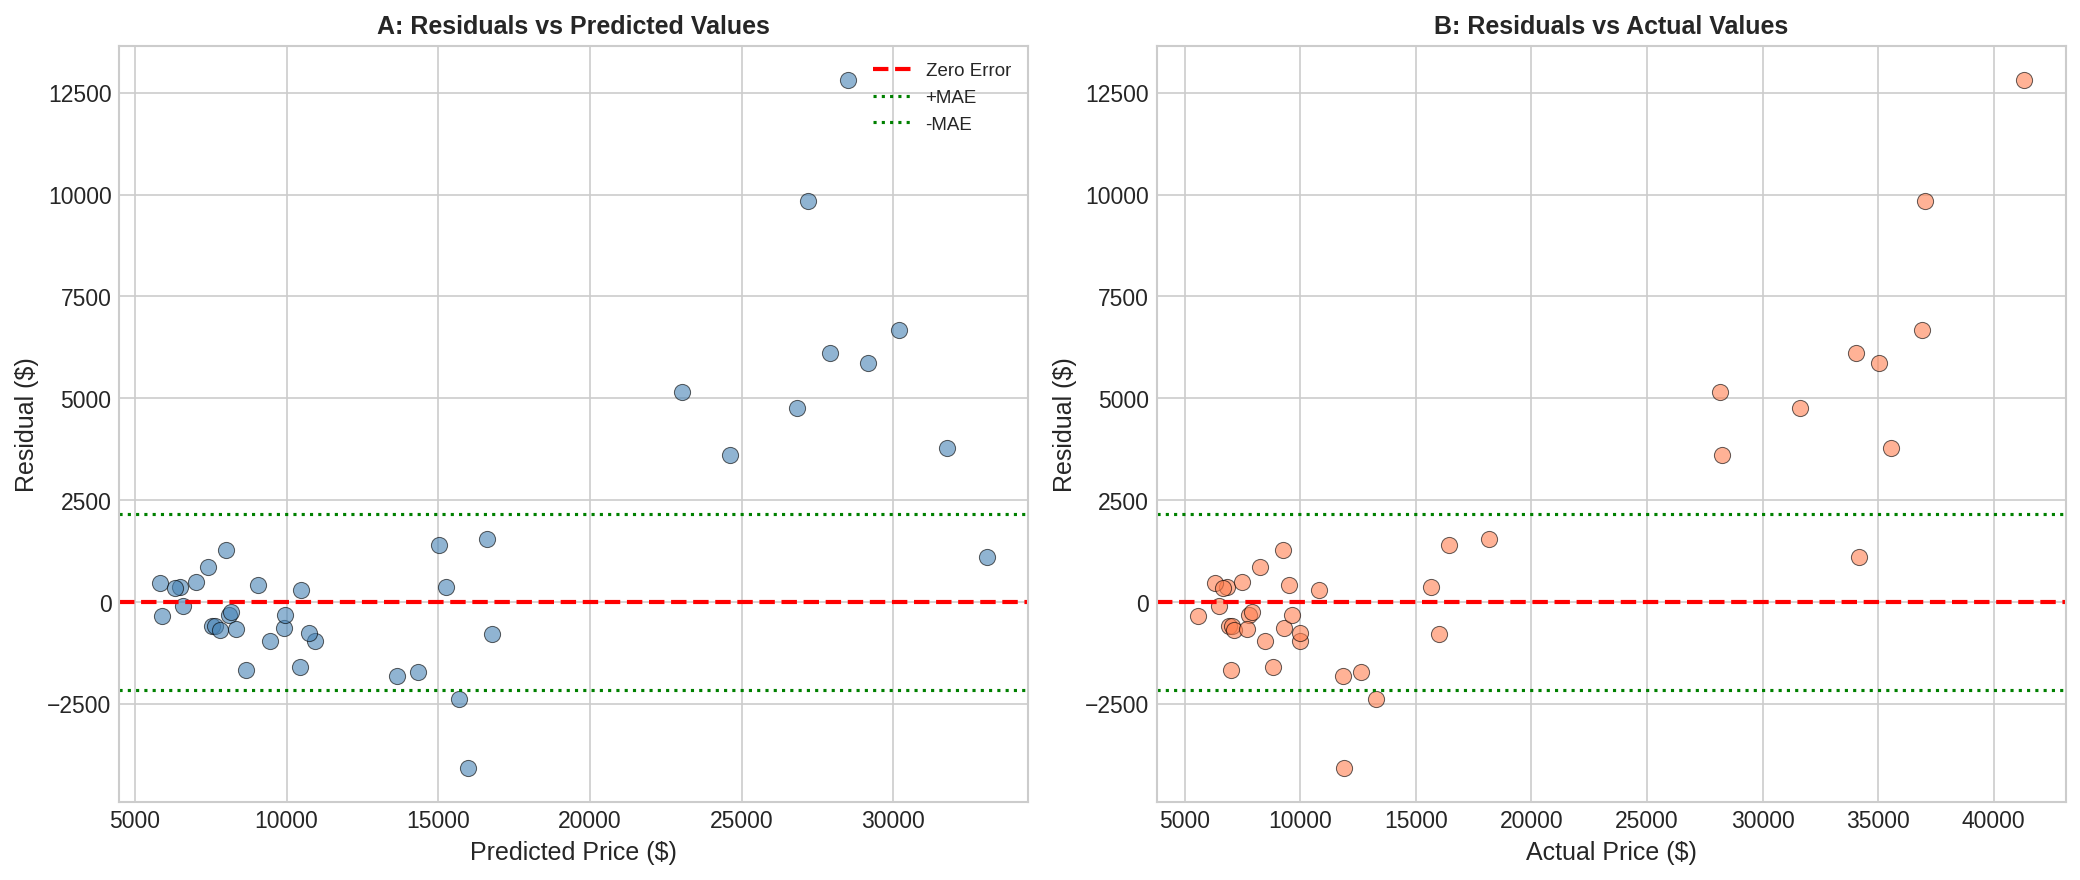

Saved: rf_fig2_residual_analysis.png

Residual Statistics:
  Mean: $1,131.33
  Std Dev: $3,311.58
  Skewness: 1.644


In [ ]:
# Figure 2: Residual Analysis
fig2, axes = plt.subplots(1, 2, figsize=(14, 6))

residuals = y_test - y_pred

# Panel A: Residuals vs Predicted
ax2a = axes[0]
ax2a.scatter(y_pred, residuals, alpha=0.6, edgecolors='black', linewidth=0.5, s=60, color='steelblue')
ax2a.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2a.axhline(y=mae, color='green', linestyle=':', linewidth=1.5, label=f'+MAE')
ax2a.axhline(y=-mae, color='green', linestyle=':', linewidth=1.5, label=f'-MAE')
ax2a.set_xlabel('Predicted Price ($)', fontsize=12)
ax2a.set_ylabel('Residual ($)', fontsize=12)
ax2a.set_title('A: Residuals vs Predicted Values', fontsize=12, fontweight='bold')
ax2a.legend(loc='upper right', fontsize=9)

# Panel B: Residuals vs Actual
ax2b = axes[1]
ax2b.scatter(y_test, residuals, alpha=0.6, edgecolors='black', linewidth=0.5, s=60, color='coral')
ax2b.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2b.axhline(y=mae, color='green', linestyle=':', linewidth=1.5)
ax2b.axhline(y=-mae, color='green', linestyle=':', linewidth=1.5)
ax2b.set_xlabel('Actual Price ($)', fontsize=12)
ax2b.set_ylabel('Residual ($)', fontsize=12)
ax2b.set_title('B: Residuals vs Actual Values', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('rf_fig2_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: rf_fig2_residual_analysis.png")

# Residual statistics
print("\nResidual Statistics:")
print(f"  Mean: ${residuals.mean():,.2f}")
print(f"  Std Dev: ${residuals.std():,.2f}")
print(f"  Skewness: {stats.skew(residuals):.3f}")

### 10.3 Error Distribution

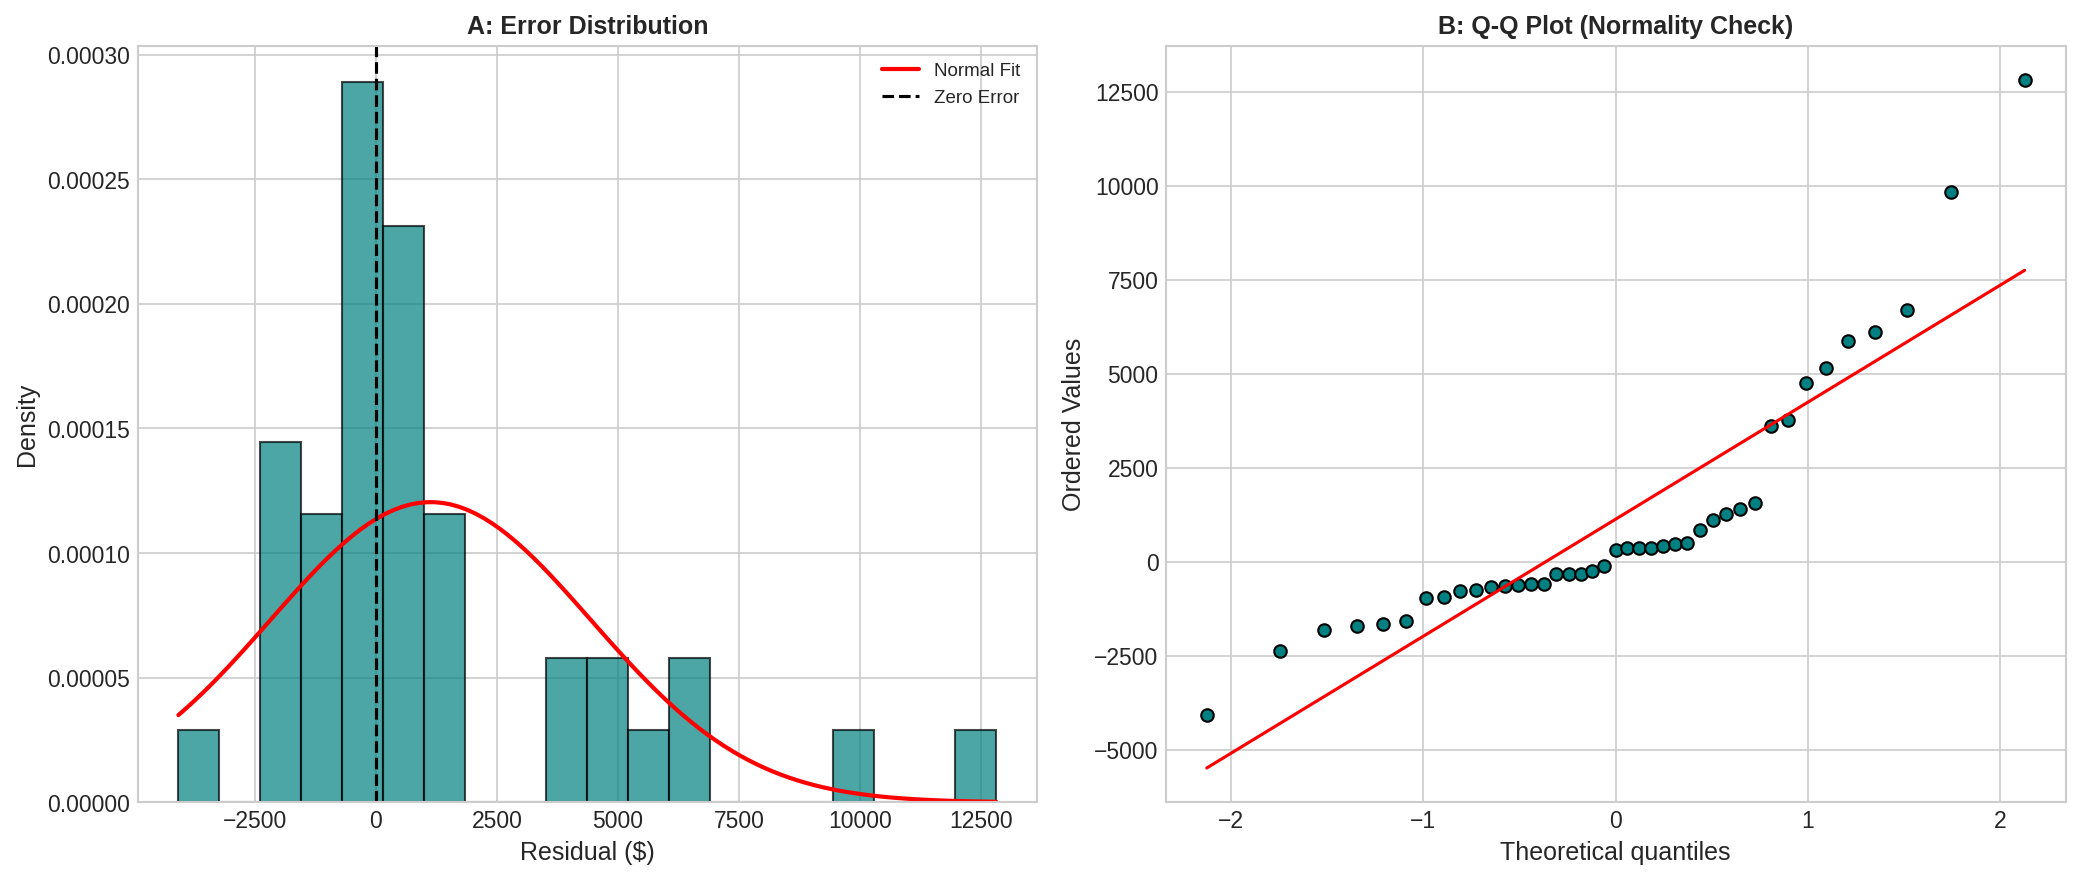

Saved: rf_fig3_error_distribution.png

Shapiro-Wilk Test: p-value = 0.0000
Residuals deviate from normality (p < 0.05)


In [ ]:
# Figure 3: Error Distribution
fig3, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Histogram
ax3a = axes[0]
n, bins, patches = ax3a.hist(residuals, bins=20, density=True, alpha=0.7,
                              color='teal', edgecolor='black')

# Normal fit
mu, std = stats.norm.fit(residuals)
x = np.linspace(residuals.min(), residuals.max(), 100)
pdf = stats.norm.pdf(x, mu, std)
ax3a.plot(x, pdf, 'r-', linewidth=2, label=f'Normal Fit')
ax3a.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Zero Error')

ax3a.set_xlabel('Residual ($)', fontsize=12)
ax3a.set_ylabel('Density', fontsize=12)
ax3a.set_title('A: Error Distribution', fontsize=12, fontweight='bold')
ax3a.legend(loc='upper right', fontsize=9)

# Panel B: Q-Q Plot
ax3b = axes[1]
stats.probplot(residuals, dist="norm", plot=ax3b)
ax3b.set_title('B: Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
ax3b.get_lines()[0].set_markerfacecolor('teal')
ax3b.get_lines()[0].set_markeredgecolor('black')

plt.tight_layout()
plt.savefig('rf_fig3_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: rf_fig3_error_distribution.png")

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"\nShapiro-Wilk Test: p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Residuals appear normally distributed (p > 0.05)")
else:
    print("Residuals deviate from normality (p < 0.05)")

### 10.4 Performance by Price Segment

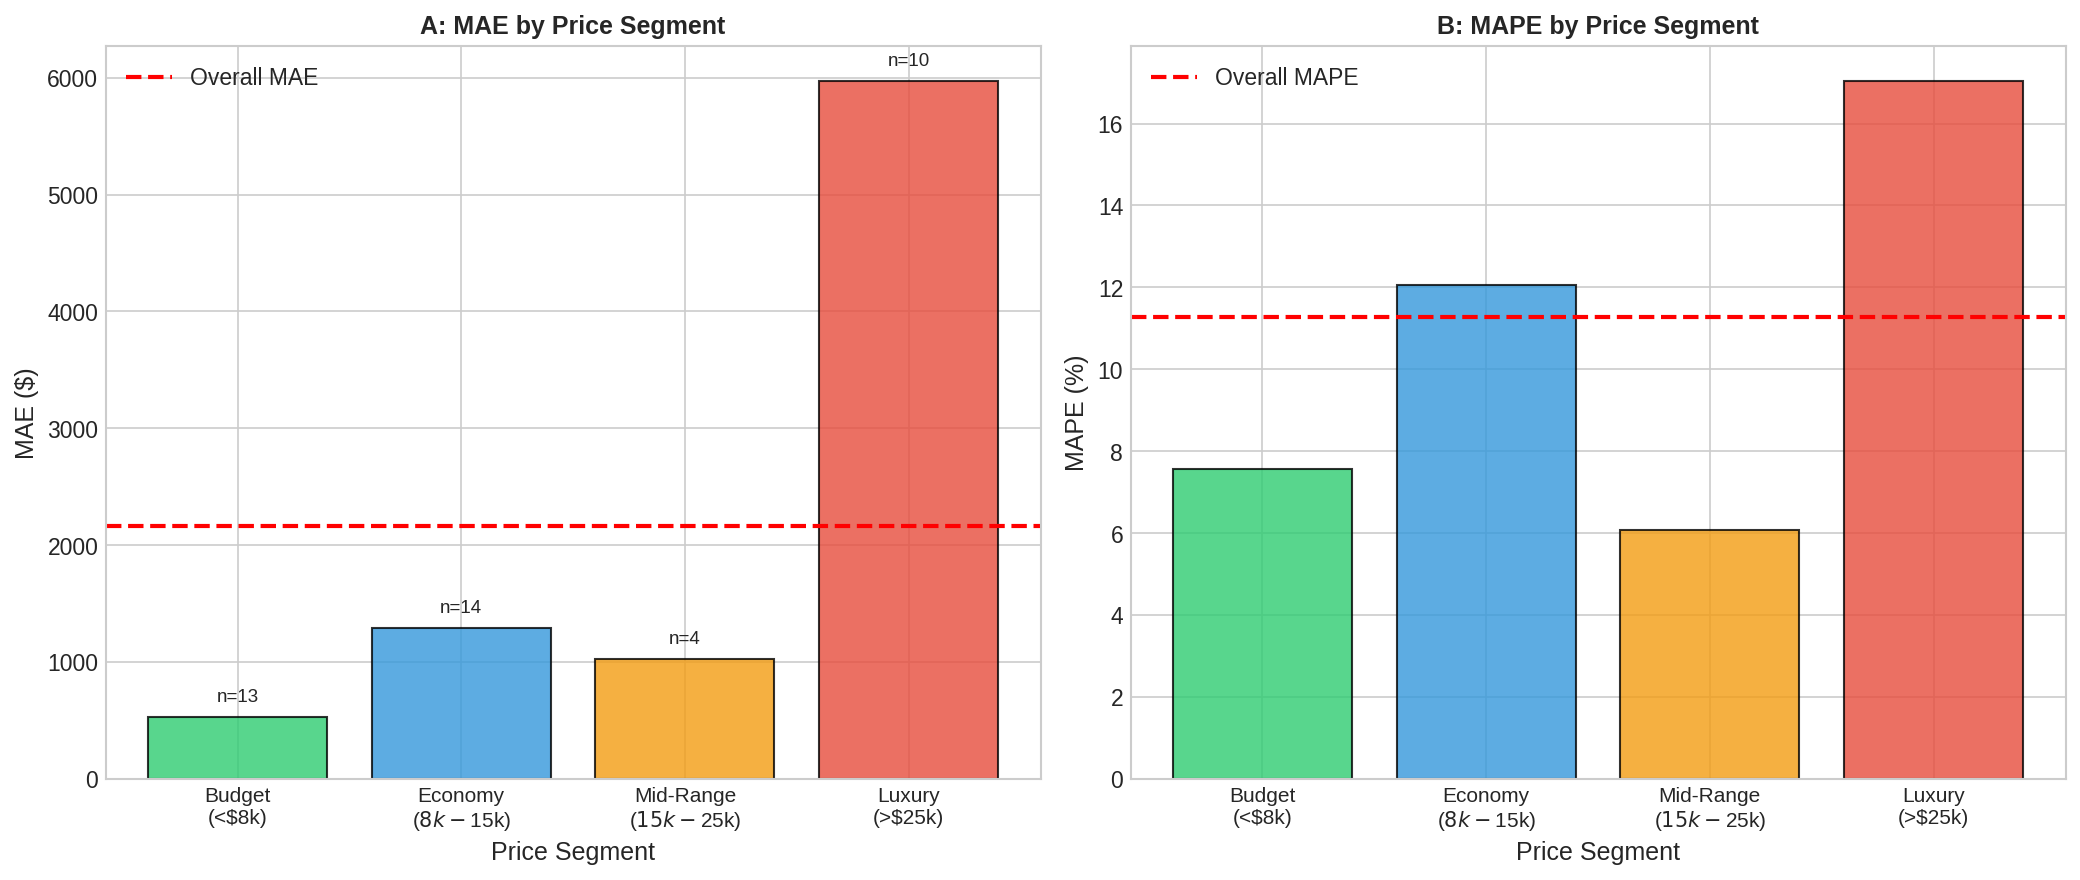

Saved: rf_fig4_performance_by_segment.png

TABLE 3: PERFORMANCE BY PRICE SEGMENT
-------------------------------------------------------
Segment                n      MAE            MAPE
-------------------------------------------------------
Budget (<$8k)          13     $       530     7.6%
Economy ($8k-$15k)     14     $     1,289    12.1%
Mid-Range ($15k-$25k)  4      $     1,026     6.1%
Luxury (>$25k)         10     $     5,973    17.0%
-------------------------------------------------------


In [ ]:
# Figure 4: Performance by Price Segment
fig4, axes = plt.subplots(1, 2, figsize=(14, 6))

# Define segments
bins = [0, 8000, 15000, 25000, 50000]
labels = ['Budget\n(<$8k)', 'Economy\n($8k-$15k)', 'Mid-Range\n($15k-$25k)', 'Luxury\n(>$25k)']

price_categories = pd.cut(y_test, bins=bins, labels=labels)

# Calculate metrics per segment
segment_metrics = []
for label in labels:
    mask = price_categories == label
    if mask.sum() > 0:
        seg_mae = mean_absolute_error(y_test[mask], y_pred[mask])
        seg_mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
        segment_metrics.append({'Segment': label, 'Count': mask.sum(), 'MAE': seg_mae, 'MAPE': seg_mape})

segment_df = pd.DataFrame(segment_metrics)

# Panel A: MAE by Segment
ax4a = axes[0]
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
bars = ax4a.bar(range(len(segment_df)), segment_df['MAE'], color=colors, edgecolor='black', alpha=0.8)
ax4a.axhline(y=mae, color='red', linestyle='--', linewidth=2, label=f'Overall MAE')
ax4a.set_xticks(range(len(segment_df)))
ax4a.set_xticklabels(labels, fontsize=10)
ax4a.set_xlabel('Price Segment', fontsize=12)
ax4a.set_ylabel('MAE ($)', fontsize=12)
ax4a.set_title('A: MAE by Price Segment', fontsize=12, fontweight='bold')
ax4a.legend()

# Add the count labels
for i, (bar, row) in enumerate(zip(bars, segment_df.itertuples())):
    ax4a.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
              f'n={row.Count}', ha='center', va='bottom', fontsize=9)

# Panel B: MAPE by Segment
ax4b = axes[1]
bars = ax4b.bar(range(len(segment_df)), segment_df['MAPE'], color=colors, edgecolor='black', alpha=0.8)
ax4b.axhline(y=mape, color='red', linestyle='--', linewidth=2, label=f'Overall MAPE')
ax4b.set_xticks(range(len(segment_df)))
ax4b.set_xticklabels(labels, fontsize=10)
ax4b.set_xlabel('Price Segment', fontsize=12)
ax4b.set_ylabel('MAPE (%)', fontsize=12)
ax4b.set_title('B: MAPE by Price Segment', fontsize=12, fontweight='bold')
ax4b.legend()

plt.tight_layout()
plt.savefig('rf_fig4_performance_by_segment.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: rf_fig4_performance_by_segment.png")

# Print table
print("\nTABLE 3: PERFORMANCE BY PRICE SEGMENT")
print("-" * 55)
print(f"{'Segment':<22} {'n':<6} {'MAE':<14} {'MAPE'}")
print("-" * 55)
for _, row in segment_df.iterrows():
    seg_name = row['Segment'].replace('\n', ' ')
    print(f"{seg_name:<22} {row['Count']:<6} ${row['MAE']:>10,.0f}   {row['MAPE']:>5.1f}%")
print("-" * 55)

---
## 11. Feature Importance Analysis

One key advantage of Random Forest is interpretability through feature importance scores. These scores represent the total reduction in impurity (Gini importance) contributed by each feature across all trees (Breiman, 2001).

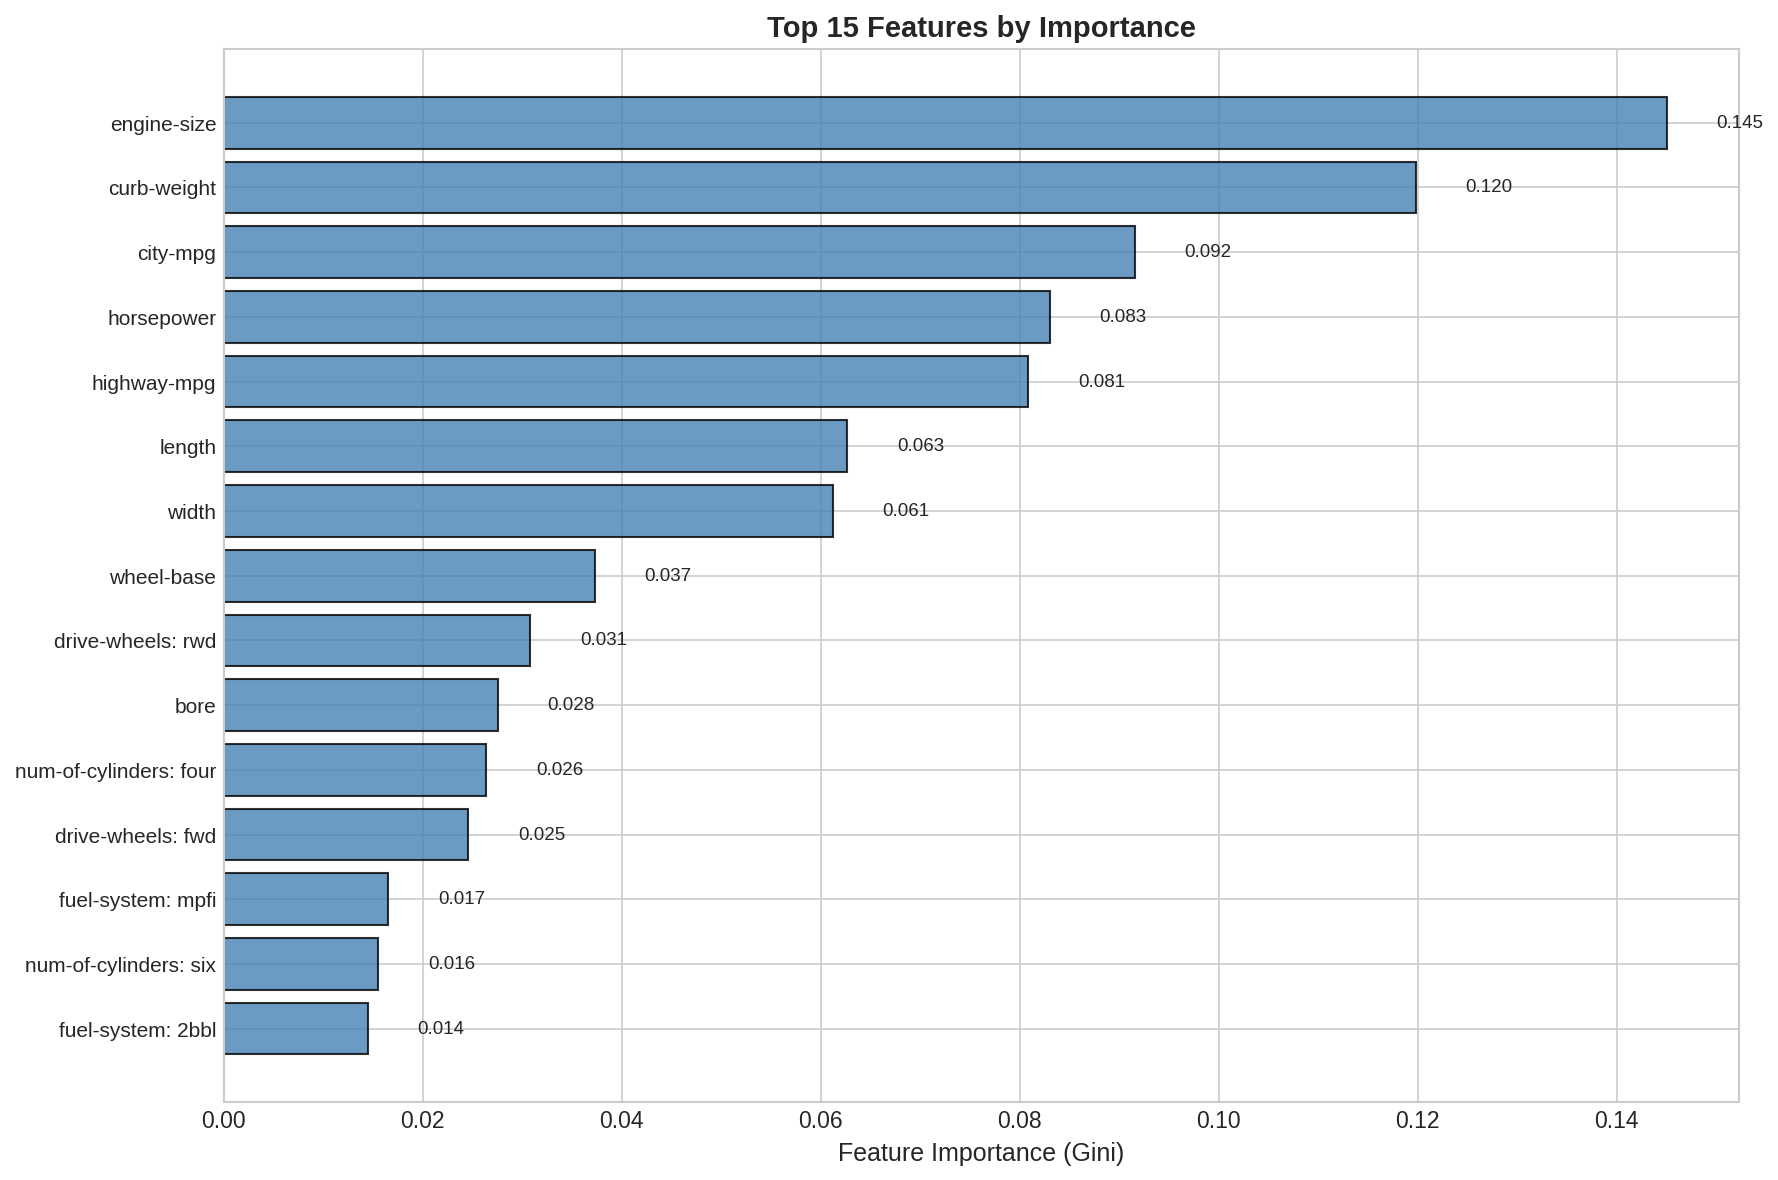

Saved: rf_fig5_feature_importance.png

TABLE 4: TOP 15 FEATURE IMPORTANCES
---------------------------------------------
Rank   Feature                      Importance
---------------------------------------------
1      engine-size                  0.1450
2      curb-weight                  0.1198
3      city-mpg                     0.0916
4      horsepower                   0.0830
5      highway-mpg                  0.0808
6      length                       0.0627
7      width                        0.0612
8      wheel-base                   0.0373
9      drive-wheels_rwd             0.0308
10     bore                         0.0276
11     num-of-cylinders_four        0.0264
12     drive-wheels_fwd             0.0246
13     fuel-system_mpfi             0.0165
14     num-of-cylinders_six         0.0156
15     fuel-system_2bbl             0.0145
---------------------------------------------


In [ ]:
# Figure 5: Feature Importance
fig5, ax5 = plt.subplots(figsize=(12, 8))

# Get feature names
numeric_features = numeric_cols
categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()
all_features = numeric_features + categorical_features

# Get importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 15
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = [all_features[i] if i < len(all_features) else f'Feature_{i}' for i in top_indices]

# Clean names
clean_names = [name.replace('_', ': ', 1) if '_' in name else name for name in top_features]

# Plot
bars = ax5.barh(range(top_n), top_importances[::-1], color='steelblue', edgecolor='black', alpha=0.8)
ax5.set_yticks(range(top_n))
ax5.set_yticklabels(clean_names[::-1], fontsize=10)
ax5.set_xlabel('Feature Importance (Gini)', fontsize=12)
ax5.set_title('Top 15 Features by Importance', fontsize=14, fontweight='bold')

# Value labels
for i, (bar, imp) in enumerate(zip(bars, top_importances[::-1])):
    ax5.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{imp:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('rf_fig5_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: rf_fig5_feature_importance.png")

# Print table
print("\nTABLE 4: TOP 15 FEATURE IMPORTANCES")
print("-" * 45)
print(f"{'Rank':<6} {'Feature':<28} {'Importance'}")
print("-" * 45)
for rank, (idx, imp) in enumerate(zip(top_indices, top_importances), 1):
    feature_name = all_features[idx] if idx < len(all_features) else f'Feature_{idx}'
    print(f"{rank:<6} {feature_name:<28} {imp:.4f}")
print("-" * 45)

### 11.1 Best and Worst Predictions

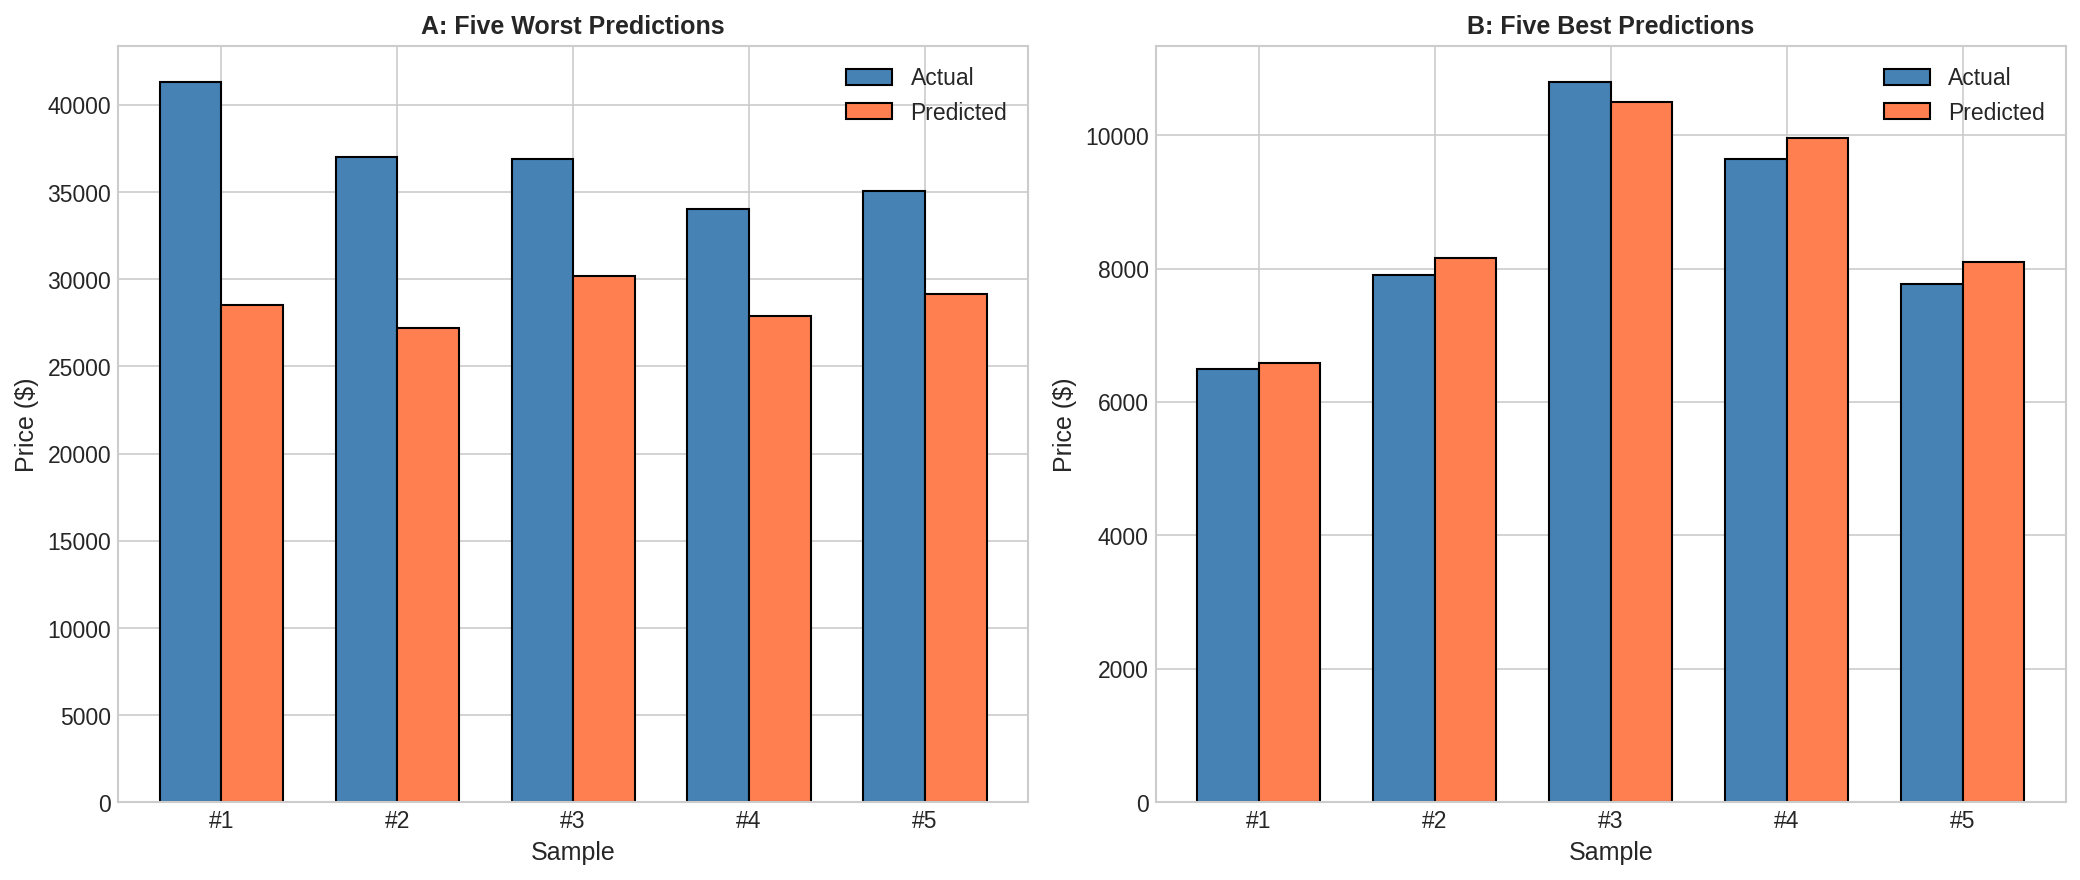

Saved: rf_fig6_extreme_predictions.png

TABLE 5: FIVE WORST PREDICTIONS
--------------------------------------------------
Actual       Predicted    Error        Error %
--------------------------------------------------
$   41,315   $   28,511   $   12,804     31.0%
$   37,028   $   27,194   $    9,834     26.6%
$   36,880   $   30,196   $    6,684     18.1%
$   34,028   $   27,907   $    6,121     18.0%
$   35,056   $   29,178   $    5,878     16.8%

TABLE 6: FIVE BEST PREDICTIONS
--------------------------------------------------
Actual       Predicted    Error        Error %
--------------------------------------------------
$    6,488   $    6,591   $     -103     -1.6%
$    7,898   $    8,154   $     -256     -3.2%
$   10,795   $   10,493   $      302      2.8%
$    9,639   $    9,954   $     -315     -3.3%
$    7,775   $    8,104   $     -329     -4.2%


In [ ]:
# Figure 6: Best and Worst Predictions
fig6, axes = plt.subplots(1, 2, figsize=(14, 6))

abs_errors = np.abs(y_test - y_pred)
worst_indices = np.argsort(abs_errors)[-5:][::-1]
best_indices = np.argsort(abs_errors)[:5]

x_pos = np.arange(5)
width = 0.35

# Panel A: Worst
ax6a = axes[0]
ax6a.bar(x_pos - width/2, y_test[worst_indices], width, label='Actual', color='steelblue', edgecolor='black')
ax6a.bar(x_pos + width/2, y_pred[worst_indices], width, label='Predicted', color='coral', edgecolor='black')
ax6a.set_xlabel('Sample', fontsize=12)
ax6a.set_ylabel('Price ($)', fontsize=12)
ax6a.set_title('A: Five Worst Predictions', fontsize=12, fontweight='bold')
ax6a.set_xticks(x_pos)
ax6a.set_xticklabels([f'#{i+1}' for i in range(5)])
ax6a.legend()

# Panel B: Best
ax6b = axes[1]
ax6b.bar(x_pos - width/2, y_test[best_indices], width, label='Actual', color='steelblue', edgecolor='black')
ax6b.bar(x_pos + width/2, y_pred[best_indices], width, label='Predicted', color='coral', edgecolor='black')
ax6b.set_xlabel('Sample', fontsize=12)
ax6b.set_ylabel('Price ($)', fontsize=12)
ax6b.set_title('B: Five Best Predictions', fontsize=12, fontweight='bold')
ax6b.set_xticks(x_pos)
ax6b.set_xticklabels([f'#{i+1}' for i in range(5)])
ax6b.legend()

plt.tight_layout()
plt.savefig('rf_fig6_extreme_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: rf_fig6_extreme_predictions.png")

# Print tables
print("\nTABLE 5: FIVE WORST PREDICTIONS")
print("-" * 50)
print(f"{'Actual':<12} {'Predicted':<12} {'Error':<12} {'Error %'}")
print("-" * 50)
for idx in worst_indices:
    actual, pred = y_test[idx], y_pred[idx]
    error = actual - pred
    print(f"${actual:>9,.0f}   ${pred:>9,.0f}   ${error:>9,.0f}   {(error/actual)*100:>6.1f}%")

print("\nTABLE 6: FIVE BEST PREDICTIONS")
print("-" * 50)
print(f"{'Actual':<12} {'Predicted':<12} {'Error':<12} {'Error %'}")
print("-" * 50)
for idx in best_indices:
    actual, pred = y_test[idx], y_pred[idx]
    error = actual - pred
    print(f"${actual:>9,.0f}   ${pred:>9,.0f}   ${error:>9,.0f}   {(error/actual)*100:>6.1f}%")

---
## 12. Results Summary

Final summary of Model 1 performance for the coursework report.

In [ ]:
print("=" * 70)
print("FINAL SUMMARY: MODEL 1 (RANDOM FOREST REGRESSOR)")
print("=" * 70)

print(f"""
MODEL ARCHITECTURE
------------------
Algorithm:          Random Forest Regressor
Type:               Ensemble (Bagging) Method
Implementation:     scikit-learn RandomForestRegressor

OPTIMISED HYPERPARAMETERS
-------------------------""")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"""
DATA CONFIGURATION
------------------
Training Samples:   {len(y_train)}
Testing Samples:    {len(y_test)}
Input Features:     {X_train.shape[1]}
Random State:       {RANDOM_STATE}

PERFORMANCE METRICS
-------------------
MAE:                ${mae:,.2f}
RMSE:               ${rmse:,.2f}
R² Score:           {r2:.4f}
MAPE:               {mape:.2f}%
Performance Rating: {rating}

BASELINE COMPARISON
-------------------
MAE Improvement:    {mae_improvement:.1f}% over mean baseline
RMSE Improvement:   {rmse_improvement:.1f}% over mean baseline

KEY FINDINGS
------------
1. Model explains {r2*100:.1f}% of automobile price variance
2. Average prediction error: ${mae:,.0f}
3. Top predictive features: {', '.join(clean_names[:3])}
4. Performance degrades on luxury vehicles (>$25,000)

GENERATED OUTPUTS
-----------------
- rf_fig1_predicted_vs_actual.png
- rf_fig2_residual_analysis.png
- rf_fig3_error_distribution.png
- rf_fig4_performance_by_segment.png
- rf_fig5_feature_importance.png
- rf_fig6_extreme_predictions.png
""")

print("=" * 70)
print("MODEL 1 IMPLEMENTATION COMPLETE")
print("=" * 70)

FINAL SUMMARY: MODEL 1 (RANDOM FOREST REGRESSOR)

MODEL ARCHITECTURE
------------------
Algorithm:          Random Forest Regressor
Type:               Ensemble (Bagging) Method
Implementation:     scikit-learn RandomForestRegressor

OPTIMISED HYPERPARAMETERS
-------------------------
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: 30

DATA CONFIGURATION
------------------
Training Samples:   160
Testing Samples:    41
Input Features:     74
Random State:       42

PERFORMANCE METRICS
-------------------
MAE:                $2,164.79
RMSE:               $3,499.50
R² Score:           0.8999
MAPE:               11.27%
Performance Rating: Very Good

BASELINE COMPARISON
-------------------
MAE Improvement:    73.8% over mean baseline
RMSE Improvement:   69.5% over mean baseline

KEY FINDINGS
------------
1. Model explains 90.0% of automobile price variance
2. Average prediction error: $2,165
3. Top predictive features: engine-size, curb-we

---
## 13. Save Results for Comparison with Model 2

In [ ]:
# Save results for Model 2 comparison
import pickle

model1_results = {
    'model_name': 'Random Forest Regressor',
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'mape': mape,
    'median_ae': median_ae,
    'max_error': max_err,
    'y_test': y_test,
    'y_pred': y_pred,
    'best_params': best_params
}

with open('model1_results.pkl', 'wb') as f:
    pickle.dump(model1_results, f)

print("Results saved to 'model1_results.pkl'")
print("\nUse this file to compare with Model 2 results.")

Results saved to 'model1_results.pkl'

Use this file to compare with Model 2 results.


---
## References

Breiman, L. (2001) 'Random Forests', Machine Learning, 45(1), pp. 5-32.

Hastie, T., Tibshirani, R. and Friedman, J. (2009) The Elements of Statistical Learning: Data Mining, Inference, and Prediction. 2nd edn. New York: Springer.

Pedregosa, F. et al. (2011) 'Scikit-learn: Machine Learning in Python', Journal of Machine Learning Research, 12, pp. 2825-2830.